# Decision Tree Classifier

This notebook guides you through implementing a Decision tree Classifier using the Breast Cance dataset. We'll cover data preparation, model trining, hyperparameter tuning, evaluation, and features importance.

# Imports

In [10]:
# Importing necesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

# For permutation importance
from sklearn.inspection import permutation_importance

# Dataset Preparation

### 2.1 Load the Breast Cancer dataset

In [11]:
# Load the Breast Cancer dataset
data = load_breast_cancer()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 2.2 Dataset Overview

In [12]:
# Basic information about the datast
print("Dataset Shape:", df.shape)
print("Features:", data.feature_names)
print("Target Classes:", data.target_names)

Dataset Shape: (569, 31)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target Classes: ['malignant' 'benign']


### 2.3 Check Class Distribution

In [13]:
class_distribution = df['target'].value_counts(normalize=True)
print(class_distribution)

target
1    0.627417
0    0.372583
Name: proportion, dtype: float64


The dataset is relatively balanced (57% malignant, 33% beingn), making it suitable for binary classification without significante imbalance concerns.

### 2.4 Data Preprocessing

**Prepre preprocesing ensures that features contribute appropiately to the model. However, Decision Trees are not sensitive to feature scaling or feature correlation, so these steps are optional**

In [14]:
# Separete features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (455, 30)
Testing set size: (114, 30)


**Note** Decision Trees not sensitive to feature scaling or highly correlated features. They can handle both without the need for scaling or feature reduction.

Therefore, we will proceed without scaling or removing correlated features.

THis simplifies the preprocessing steps and reduces computational overhead.

## Decision Tree Model - Training & Evaluation

### 3.1 Basic Decision Tree with Default Parametes

Accuracy 0.95


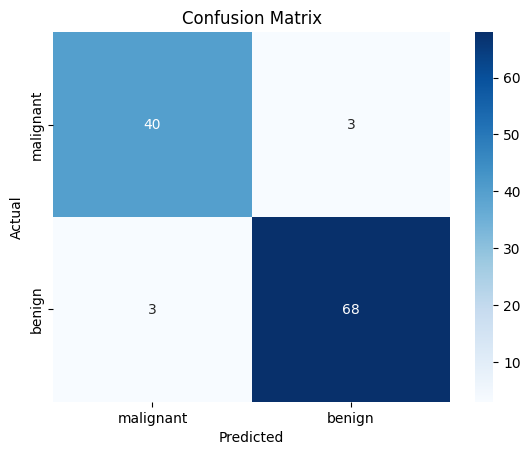

              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        43
      benign       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [15]:
# Initialize Decision Tree Classifier with default parametes
dtree = DecisionTreeClassifier(random_state=42)

# Fit the model
dtree.fit(X_train, y_train)

# Predict on test ata
y_pred = dtree.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=data.target_names))

## Hyperparameter Tuning

### GridSearch for Optimal Decision Tree Parameters

In [ ]:
# Define the parameter grid
param_grid ={
    'max_depth':[None, 3, 5, 7, 10 ,20, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv = 5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
grid.fit(X_train, y_train)

# Best parameters
print(f"Best parameters: {grid.best_params_}")

# Best cross-validation accuracy
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation accuracy: 0.95


## Retrain with Optimal Parameters

In [22]:
# Get the best parameters
best_params = grid.best_params_

# Initialize Decision Tree with best parameters
dtree_best = DecisionTreeClassifier(**best_params, random_state=42)

# Fit the model
dtree_best.fit(X_train, y_train)

# Predict on test data
y_pred_best = dtree_best.predict(X_test)

# Evaluate
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Test Accruracy with Optimal Parameters: {accuracy_best:.2f}")

Test Accruracy with Optimal Parameters: 0.96


## Cross-Validation Scores

In [23]:
# Cross-validation scores using StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_skf = cross_val_score(dtree_best, X_train, y_train, cv=skf, scoring='accuracy')

# Cross-validation scores using KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_kf = cross_val_score(dtree_best, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Mean CV Accuracy (StratifiedKFold): {cv_scores_skf.mean():.2f}")
print(f"Mean CV Accuracy (KFold): {cv_scores_kf.mean():.2f}")

Mean CV Accuracy (StratifiedKFold): 0.94
Mean CV Accuracy (KFold): 0.92


## Feature Importance

Understanding which feaatures contribute most to the model's predictions is essential for interpretation and gaining insights into the data.

### 6.1. Feature Importance from Decision Tree

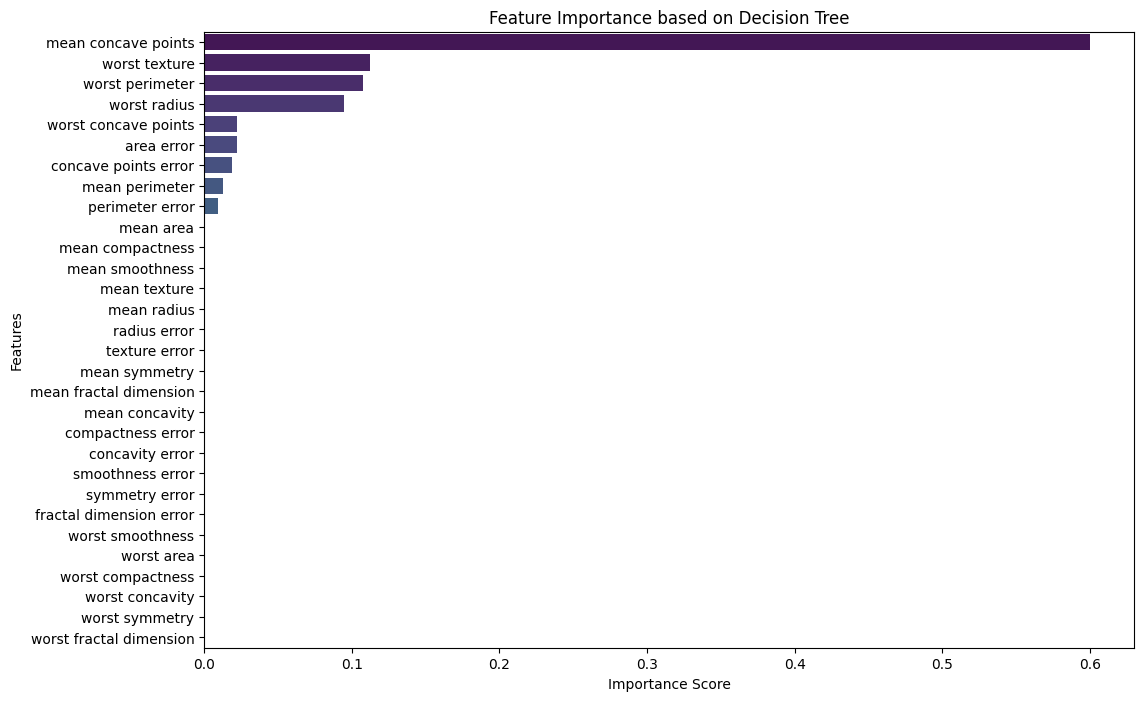

In [27]:
# Extract feature importances from the best Decision Tree model
feature_importances = pd.Series(dtree_best.feature_importances_, index=X_train.columns)

# Sort features by importance
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, 
            hue=feature_importances_sorted.index,
            palette='viridis')
plt.title('Feature Importance based on Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

### 6.2. Top Important Features

Top 10 Important Features:
mean concave points     0.600002
worst texture           0.112280
worst perimeter         0.107362
worst radius            0.094622
worst concave points    0.022416
area error              0.022019
concave points error    0.018943
mean perimeter          0.013099
perimeter error         0.009256
mean area               0.000000
dtype: float64


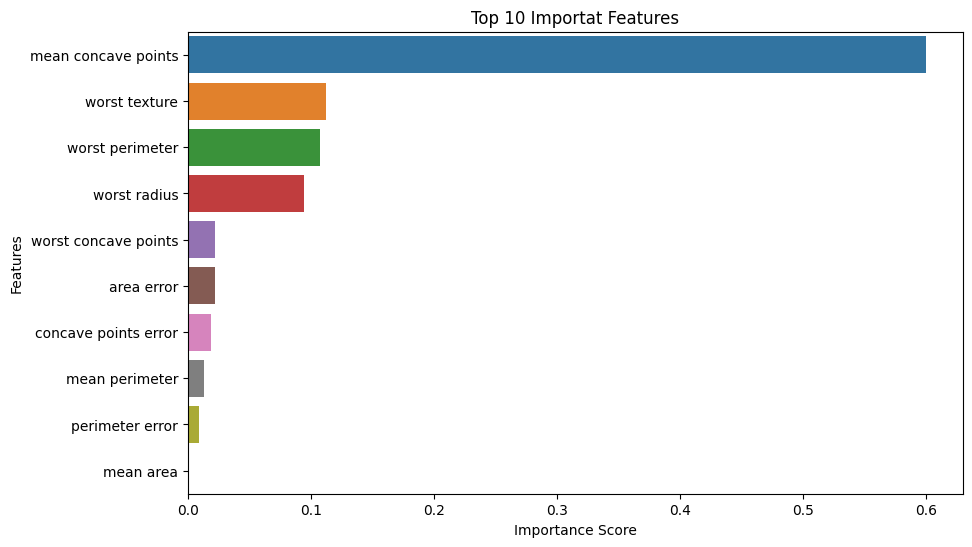

In [28]:
# Display top 10 important features
top_features  = feature_importances_sorted.head(10)
print("Top 10 Important Features:")
print(top_features)

# Plotting top featues
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette='tab10')
plt.title('Top 10 Importat Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## 6.3 Visualizing the Decision Tree

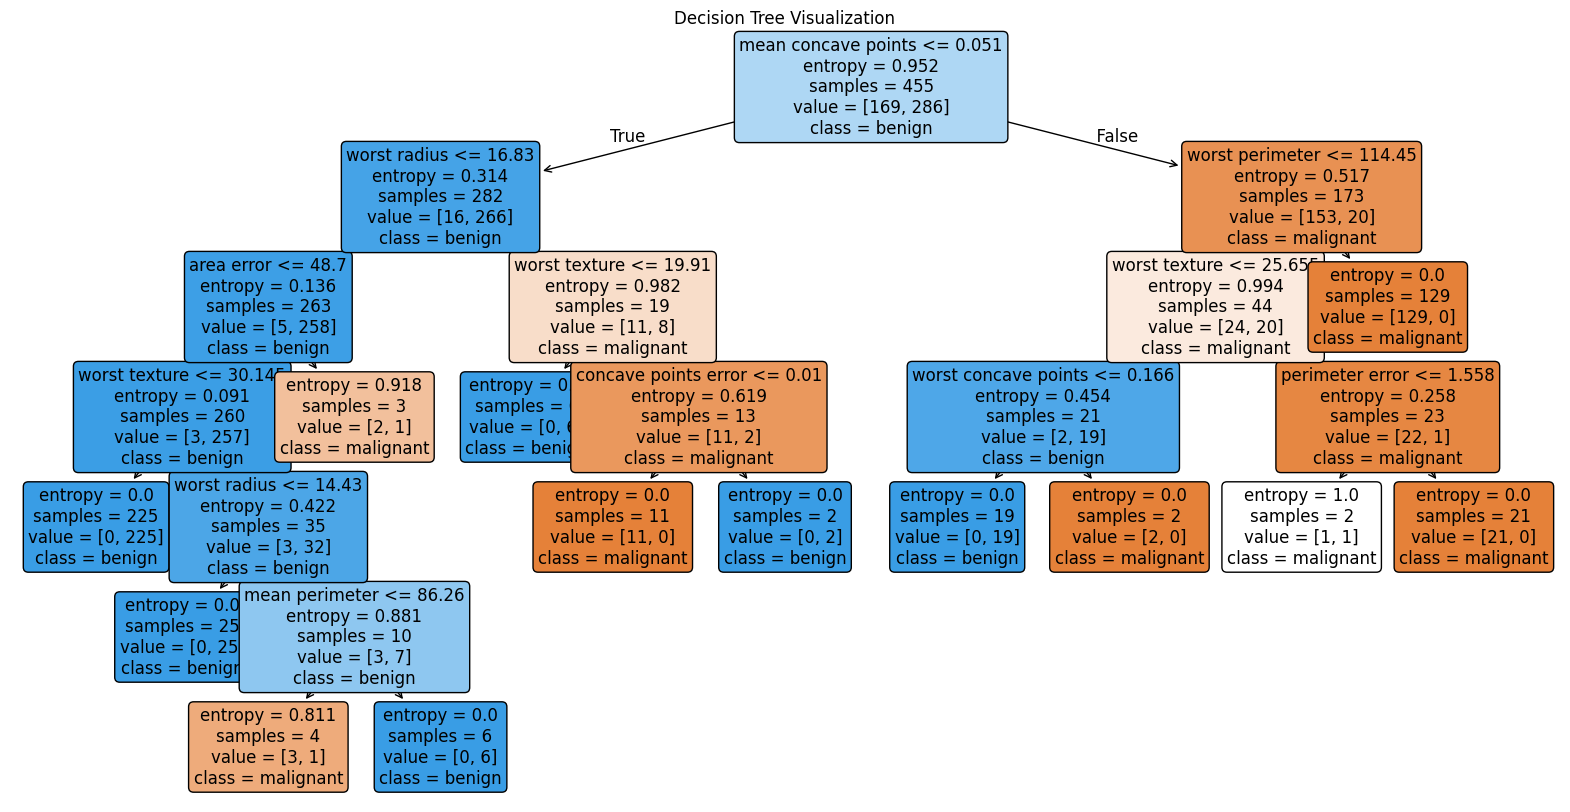

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(
    dtree_best,
    feature_names=X_train.columns,
    class_names=data.target_names,
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title('Decision Tree Visualization')
plt.show()

## 6.4 Permutation Importance

Permutation Importance measures the increase in the model's prediction error when a single feature's values are randomly shuffled.

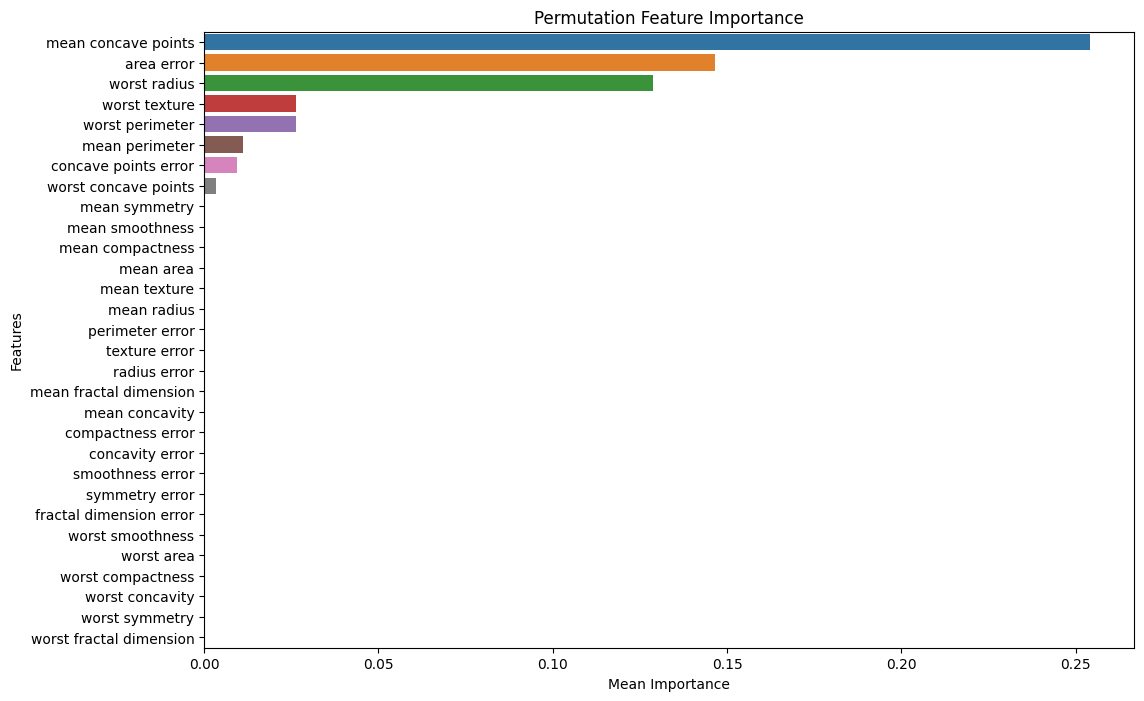

In [31]:
# Compute permutation importance on the best model
perm_importance = permutation_importance(
    dtree_best, X_test, y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# Create a DataFrame for feature importance
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance Mean',
    y='Feature',
    hue='Feature',
    legend=False,
    data=perm_importance_df,
    palette='tab10'
)
plt.title('Permutation Feature Importance')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.show()

## Advanced Decision Tree Techniques

In this section, we'll explore advanced techniques for enhancing Decision Tree models, focusing on Pruning to prevent overfitting and improve model generalization

## 7.1 Cost-Complexity Pruning (Post-Pruning)

Pruning helps in reducing the complexity of the Decision Tree, thereby preventing overfitting.

Scikit-learn provides a parameter called ccp_alpha using cross-validation

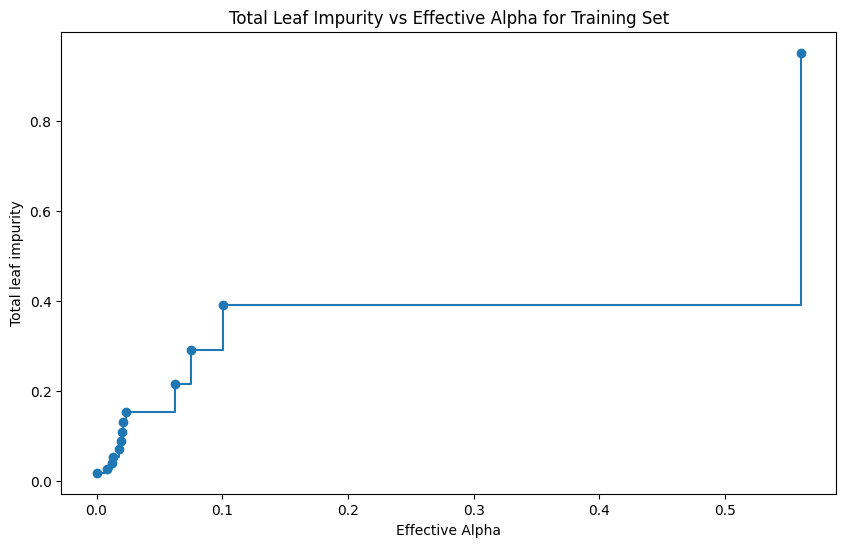

In [32]:
# Import necessary library for cost-complexity pruning
from sklearn.tree import DecisionTreeClassifier

# Retrvie effective alphas and corresponding total leaf impurities
path = dtree_best.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plat total leaf impurities vs effective alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
plt.xlabel("Effective Alpha")
plt.ylabel("Total leaf impurity")
plt.title("Total Leaf Impurity vs Effective Alpha for Training Set")
plt.show()